In [1]:
# -------------------------------------------------------------
# CODTECH PYTHON INTERNSHIP - TASK 4
# MACHINE LEARNING AND MODEL IMPLEMENTATION
# PROJECT: BREAST CANCER DETECTION USING SCIKIT-LEARN
# -------------------------------------------------------------

In [2]:
# Step 1: Import required libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
# -------------------------------------------------------------
# Step 2: Load the dataset (built-in sklearn dataset)
# -------------------------------------------------------------
data = load_breast_cancer()

# Convert to pandas for nicer handling
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0 = malignant, 1 = benign

# Quick look at the data
print("Dataset shape:", X.shape)
print("Target distribution (0=malignant, 1=benign):")
print(y.value_counts())

print("\nFeature names (first 10):", list(X.columns[:10]))

Dataset shape: (569, 30)
Target distribution (0=malignant, 1=benign):
target
1    357
0    212
Name: count, dtype: int64

Feature names (first 10): ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension']


In [4]:
# -------------------------------------------------------------
# Step 3: (Optional) Basic data checks / preprocessing notes
# -------------------------------------------------------------
# Check for missing values (there are none in this dataset)
print("\nMissing values per column:\n", X.isnull().sum().head())

# Note: Features are numeric already; we'll scale them before training.


Missing values per column:
 mean radius        0
mean texture       0
mean perimeter     0
mean area          0
mean smoothness    0
dtype: int64


In [5]:
# -------------------------------------------------------------
# Step 4: Split the dataset into training and testing sets
# -------------------------------------------------------------
# We'll stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 455
Testing samples: 114


In [6]:
# -------------------------------------------------------------
# Step 5: Build pipelines (scaling + classifier)
# We'll prepare two models to compare: Logistic Regression and RandomForest
# -------------------------------------------------------------
pipe_logreg = Pipeline(
    [("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=10000, random_state=42))]
)
pipe_rf = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))])

# Small hyperparameter grids for demonstration
param_grid_logreg = {"clf__C": [0.01, 0.1, 1, 10]}
param_grid_rf = {"clf__n_estimators": [50, 100], "clf__max_depth": [None, 5, 10]}

# Use GridSearchCV to find best params by ROC-AUC (fast small search)
gs_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, scoring="roc_auc", n_jobs=-1)
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring="roc_auc", n_jobs=-1)

In [7]:
# -------------------------------------------------------------
# Step 6: Train (fit) the models
# -------------------------------------------------------------
print("\nTraining Logistic Regression (GridSearch)...")
gs_logreg.fit(X_train, y_train)
print("Best Logistic params:", gs_logreg.best_params_)
print("Logistic CV ROC-AUC:", gs_logreg.best_score_)

print("\nTraining Random Forest (GridSearch)...")
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_)
print("RandomForest CV ROC-AUC:", gs_rf.best_score_)

# Choose best estimators
best_logreg = gs_logreg.best_estimator_
best_rf = gs_rf.best_estimator_


Training Logistic Regression (GridSearch)...
Best Logistic params: {'clf__C': 0.1}
Logistic CV ROC-AUC: 0.9936016511867904

Training Random Forest (GridSearch)...
Best RF params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
RandomForest CV ROC-AUC: 0.9888544891640867


In [8]:
# -------------------------------------------------------------
# Step 7: Model Prediction and Evaluation on Test Set
# -------------------------------------------------------------
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate classifier and print metrics. Returns predicted probabilities (if available)."""
    y_pred = model.predict(X_test)
    # Get probability / score for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]  # probability for class 1 (benign)
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"\n{model_name} - Test Accuracy: {acc:.4f}")
    if auc is not None:
        print(f"{model_name} - Test ROC AUC: {auc:.4f}")
    print(f"{model_name} - Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"{model_name} - Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    return y_prob, y_pred

print("\nEvaluating Logistic Regression on test set...")
yprob_log, ypred_log = evaluate_model(best_logreg, X_test, y_test, "LogisticRegression")

print("\nEvaluating Random Forest on test set...")
yprob_rf, ypred_rf = evaluate_model(best_rf, X_test, y_test, "RandomForest")


Evaluating Logistic Regression on test set...

LogisticRegression - Test Accuracy: 0.9737
LogisticRegression - Test ROC AUC: 0.9957
LogisticRegression - Confusion Matrix:
 [[40  2]
 [ 1 71]]
LogisticRegression - Classification Report:
               precision    recall  f1-score   support

           0     0.9756    0.9524    0.9639        42
           1     0.9726    0.9861    0.9793        72

    accuracy                         0.9737       114
   macro avg     0.9741    0.9692    0.9716       114
weighted avg     0.9737    0.9737    0.9736       114


Evaluating Random Forest on test set...

RandomForest - Test Accuracy: 0.9561
RandomForest - Test ROC AUC: 0.9934
RandomForest - Confusion Matrix:
 [[39  3]
 [ 2 70]]
RandomForest - Classification Report:
               precision    recall  f1-score   support

           0     0.9512    0.9286    0.9398        42
           1     0.9589    0.9722    0.9655        72

    accuracy                         0.9561       114
   macro av

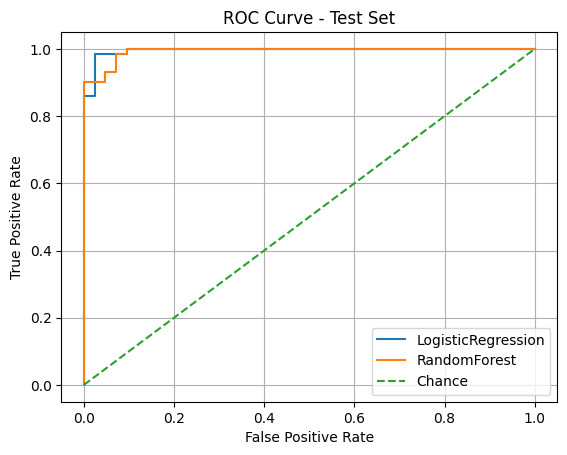

In [9]:
# -------------------------------------------------------------
# Step 8: ROC Curve plot (Logistic vs Random Forest)
# -------------------------------------------------------------
fpr_log, tpr_log, _ = roc_curve(y_test, yprob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, yprob_rf)

plt.figure()
plt.plot(fpr_log, tpr_log, label="LogisticRegression")
plt.plot(fpr_rf, tpr_rf, label="RandomForest")
plt.plot([0, 1], [0, 1], "--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# -------------------------------------------------------------
# Step 9: Feature importance (for Random Forest) & coefficients (for Logistic)
# -------------------------------------------------------------
# Random Forest feature importances
rf_clf = best_rf.named_steps["clf"]
importances = rf_clf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nTop 10 feature importances (Random Forest):\n", feat_imp.head(10))

# Logistic Regression coefficients (absolute values, top features)
log_clf = best_logreg.named_steps["clf"]
coefs = pd.Series(np.abs(log_clf.coef_[0]), index=X.columns).sort_values(ascending=False)
print("\nTop 10 coefficient magnitudes (Logistic Regression):\n", coefs.head(10))


Top 10 feature importances (Random Forest):
 worst area              0.138294
worst concave points    0.132993
worst radius            0.100805
mean concave points     0.098489
worst perimeter         0.072224
mean perimeter          0.068612
mean radius             0.067465
mean concavity          0.057445
mean area               0.050615
worst concavity         0.031544
dtype: float64

Top 10 coefficient magnitudes (Logistic Regression):
 worst texture           0.563530
worst radius            0.509038
worst concave points    0.507791
worst perimeter         0.465531
worst area              0.460311
mean texture            0.439772
radius error            0.439074
worst symmetry          0.412812
mean concave points     0.403913
mean radius             0.397267
dtype: float64


In [11]:
# -------------------------------------------------------------
# Step 10: Save the chosen model (example: save Random Forest)
# -------------------------------------------------------------
model_path = "best_random_forest_breast_cancer.joblib"
joblib.dump(best_rf, model_path)
print(f"\nSaved Random Forest pipeline to '{model_path}'")


Saved Random Forest pipeline to 'best_random_forest_breast_cancer.joblib'


In [12]:
# -------------------------------------------------------------
# Step 11: Helper function to predict on custom input
# Accepts either:
#  - a dict mapping feature names -> values, OR
#  - a list/array of values in the same order as data.feature_names
# -------------------------------------------------------------
def predict_custom(sample):
    """
    Predicts whether sample is malignant (0) or benign (1).
    Args:
        sample: dict {feature_name: value} OR list/array of feature values in correct order
    Returns:
        dict with prediction label, predicted probability for class 1, and class index.
    """
    # Prepare input array
    if isinstance(sample, dict):
        # Ensure order matches feature names
        values = [sample.get(f, np.nan) for f in data.feature_names]
        arr = np.array(values, dtype=float).reshape(1, -1)
    else:
        arr = np.array(sample, dtype=float).reshape(1, -1)

    # If there are missing values, raise informative error
    if np.isnan(arr).any():
        raise ValueError("Input contains NaN. Provide all feature values or check feature names.")

    # Use the saved best model (Random Forest pipeline) to predict
    pred_class = best_rf.predict(arr)[0]         # 0 or 1
    pred_prob = best_rf.predict_proba(arr)[0, 1]  # probability of class 1 (benign)

    label = "BENIGN" if pred_class == 1 else "MALIGNANT"
    return {"prediction": label, "class": int(pred_class), "probability_class_1": float(pred_prob)}

In [13]:
# -------------------------------------------------------------
# Step 12: Example usage of predict_custom with a sample from the test set
# -------------------------------------------------------------
# Take the first test row as example (convert to list)
example_row = X_test.iloc[0].values  # list of feature values
print("\nExample: Predicting for one sample pulled from test set (true label = {})".format(y_test.iloc[0]))
example_result = predict_custom(example_row)
print("Prediction result:", example_result)

# Or use a dict input (show only 5 features for brevity - fill all in real cases)
example_dict = {name: float(X_test.iloc[0][name]) for name in data.feature_names}
example_result2 = predict_custom(example_dict)
print("Prediction result using dict input (same sample):", example_result2)


Example: Predicting for one sample pulled from test set (true label = 0)
Prediction result: {'prediction': 'MALIGNANT', 'class': 0, 'probability_class_1': 0.0003927220927220927}
Prediction result using dict input (same sample): {'prediction': 'MALIGNANT', 'class': 0, 'probability_class_1': 0.0003927220927220927}
